<a href="https://colab.research.google.com/github/xcncxoxo/filters/blob/main/filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2. Filtros sobre Imágenes

## Introducción

En este proyecto se trabajó con el conjunto de datos [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), aplicando filtros a las imágenes para explorar cómo afectan la visualización y la preparación de datos para tareas, por ejemplo, de clasificación. Este tipo de preprocesamiento es utilizado sobre todo para visión por computadora ya que resalta características relevantes de las imágenes.

## Objetivo
Aplicar distintos filtros a las primeras imágenes del conjunto de datos CIFAR-10, analizar su efecto visual y justificar su uso en tareas de clasificación.
Evaluar el impacto del filtro aplicado en una tarea de claisifación y comparar cómo afecta al rendimiento del modelo. Analizar si el filtro mejor o empeora la precisión del modelo.

### Conjunto de datos
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) es un conjunto de imágenes a color de 32x32 píxeles, dividido en 10 clases (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). Cada clase contiene 6,000 imágenes. En este proyecto se utiliza el archivo `data_batch_1`.

## Aplicación de filtros

Primero se probó aplicar los filtros para una sola imagen.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_cifar_batch(filename): ## esto solo es para cargar los archivos
    with open(filename, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        data = dict[b'data']
        labels = dict[b'labels']
        return data, labels

In [3]:
data, labels = load_cifar_batch('/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_1')

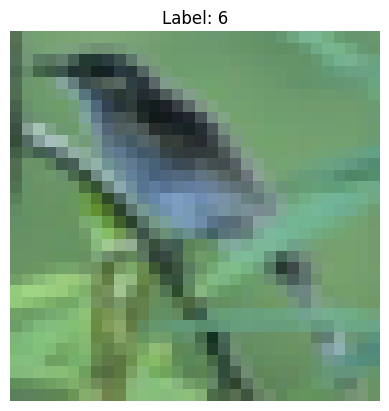

In [4]:
# mostramos alguna imagen
img = data[800]
img = img.reshape(3, 32, 32).transpose(1, 2, 0)
plt.imshow(img)
plt.title(f'Label: {labels[0]}')
plt.axis('off')
plt.show()

In [5]:
# exploramos un poco nuestra base
def load_label_names():
    with open('/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/batches.meta', 'rb') as f:
        labels = pickle.load(f, encoding='bytes')[b'label_names']
        return [label.decode('utf-8') for label in labels]

label_names = load_label_names()
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
import cv2
from scipy.ndimage import gaussian_filter, sobel

#### Desenfoque (Gaussian Blur)

Difumina la imagen, suaviza detalles y reduce el ruido. Promedia los colores con los píxeles vecinos, dando un efecto "borroso" (_blur_).

Es ideal para eliminar el ruido antes de aplicar otros filtros. Restalta patrones grandes (ignora los detalles finos).

El _ruido_, puede interferir en procesos de clasificación y detección de bordes.

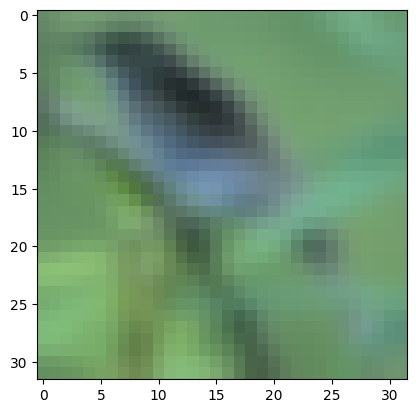

In [7]:
img_blur = cv2.GaussianBlur(img, (5, 5), 1)
plt.imshow(img_blur)

#### Detección de bordes (Sobel)

Detecta los cambios abruptos en la intensidad de los pixeles. Restalta los contornos de la imagen.

Extrae formas y estructuras. Se usa sobre todo cuando los colores no bastan para clasificar objetos.

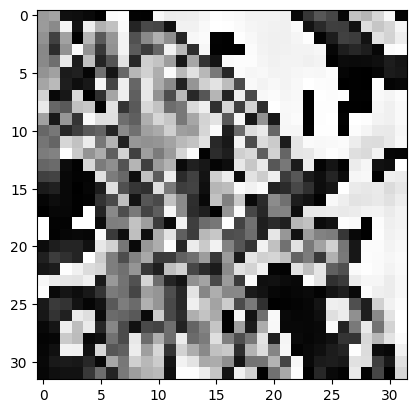

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edges = sobel(gray)
plt.imshow(edges, cmap='gray')

#### Mejora de detalles (Sharperning)

Aumenta el contraste en los bordes, por lo que las imágenes se ven más nítidas. A diferencia de `Gaussian Blur`, resalta líneas y detalles finos.

Sirve para destacar contornos y mejorar la percepción visual.

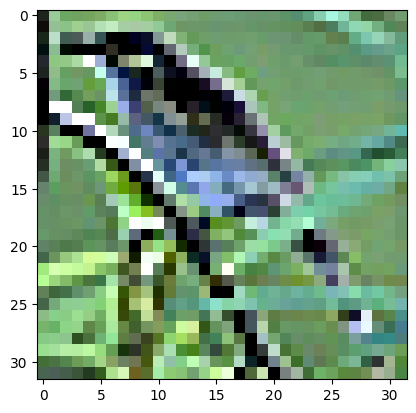

In [9]:
kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
sharpened = cv2.filter2D(img, -1, kernel)
plt.imshow(sharpened)

Después se probó aplicar los filtros para varias imágenes y comparaarlos.

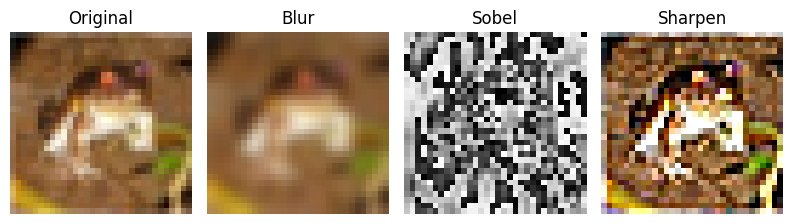

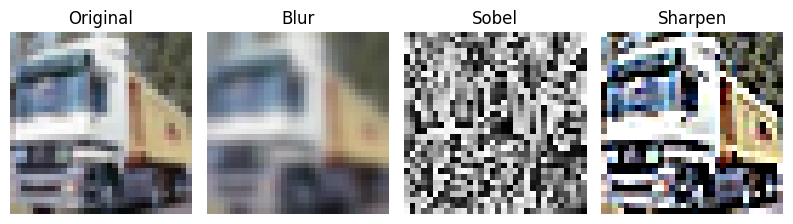

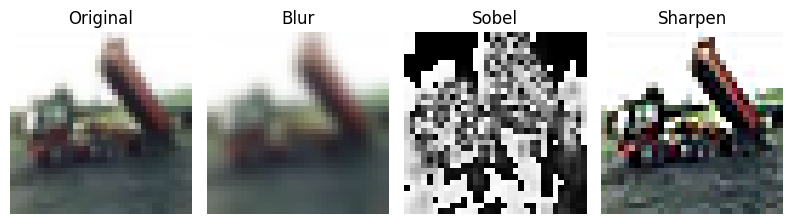

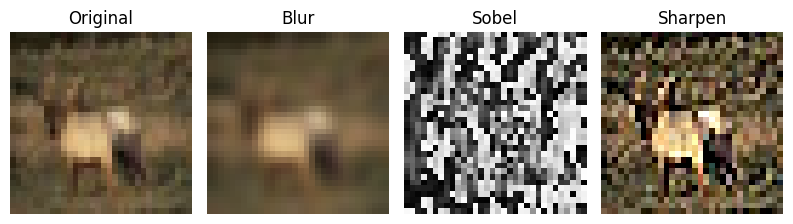

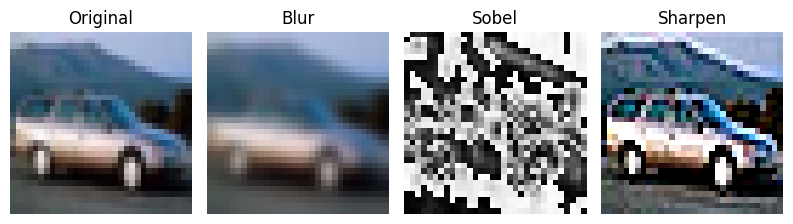

In [10]:
for i in range(5):
    img = data[i].reshape(3, 32, 32).transpose(1, 2, 0)

    blur_img = cv2.GaussianBlur(img, (5, 5), 1)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edge_img = sobel(gray)

    kernel_sharpening = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    sharpen_img = cv2.filter2D(img, -1, kernel_sharpening)

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(blur_img)
    plt.title("Blur")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(edge_img, cmap='gray')
    plt.title("Sobel")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(sharpen_img)
    plt.title("Sharpen")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Clasificación de imágenes

Se entrenará un modelo que reciba una imagen y prediga a qué clase pertenece de las siguientes:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

### Clasificación sin filtro

Se eligió un modelo de clasificación con Keras ya que puede alcanzar más del 50% de precisión y es más rápido.

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## siempre es importante normalizar/escalar los datos
## en este caso estamos norlamizando
X = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0  # (N, C, H, W) → (N, H, W, C)
y = np.array(labels)
y_cat = to_categorical(y, 10)

# dividir conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# modelo con keras
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# entrenamos
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=64)

# accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nPrecisión en test:", test_acc)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.2026 - loss: 2.1467 - val_accuracy: 0.3325 - val_loss: 1.8079
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.3945 - loss: 1.6773 - val_accuracy: 0.4187 - val_loss: 1.5872
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.4618 - loss: 1.4782 - val_accuracy: 0.4650 - val_loss: 1.4964
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5157 - loss: 1.3662 - val_accuracy: 0.4712 - val_loss: 1.4601
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.5554 - loss: 1.2561 - val_accuracy: 0.4963 - val_loss: 1.4531
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.5609 - loss: 1.2344 - val_accuracy: 0.5200 - val_loss: 1.3523
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.6048 - loss: 1.1160 - val_accuracy: 0.5325 - val_loss: 1.3234
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.6298 - loss: 1.0585 - v

Ojo al accuracy del conjunto de validación.

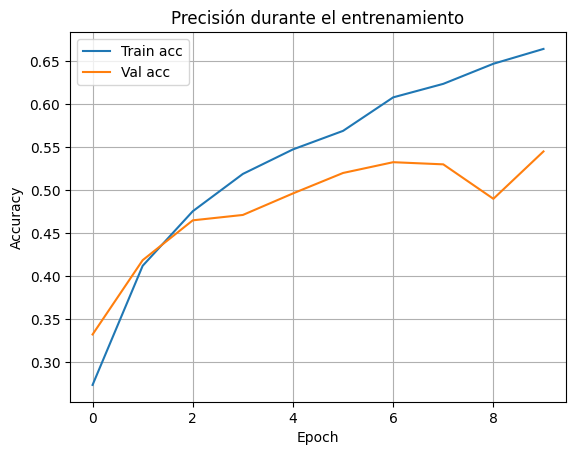

In [12]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.grid(True)
plt.show()

### Clasificación con filtros

Probamos suerte con los filtros para ver cuál nos da un mejor rendimiento.

In [13]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Etiquetas
y_cat = to_categorical(np.array(labels), 10)

# Función general para entrenar y obtener precisión final
def train_and_evaluate(X_input, y_input, title):
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_cat, test_size=0.2, random_state=42)
    model = build_model()
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=0)
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{title}: Precisión = {acc:.4f}")
    return history, acc

#### Gaussian Blur

In [27]:
## normalizamos
X_norm = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
## usaremos el mismo conjunto normalizado para los tres casos
# aplicamos gaussian blurr
def apply_gaussian_blur(images, ksize=(3,3)):
    blurred = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)
        img_blur = cv2.GaussianBlur(img_uint8, ksize, 0)
        blurred.append(img_blur.astype(np.float32) / 255.0)
    return np.array(blurred)

In [28]:
X_blur = apply_gaussian_blur(X_norm)

In [29]:
h_blur, acc_blur = train_and_evaluate(X_blur, y_cat, "Gaussian Blur")

Gaussian Blur: Precisión = 0.5085


#### Sobel

In [30]:
# aplicar sobel
def apply_sobel(images):
    sobel_imgs = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = np.clip(sobel / sobel.max(), 0, 1)
        sobel_3ch = np.stack([sobel]*3, axis=-1)
        sobel_imgs.append(sobel_3ch)
    return np.array(sobel_imgs)

In [31]:
X_sobel = apply_sobel(X_norm)

In [32]:
h_sobel, acc_sobel = train_and_evaluate(X_sobel, y_cat, "Sobel")

Sobel: Precisión = 0.5140


#### Sharperning

In [23]:
# aplicar sharpening
def apply_sharpen(images):
    sharpened = []
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)
        img_sharp = cv2.filter2D(img_uint8, -1, kernel)
        sharpened.append(img_sharp.astype(np.float32) / 255.0)
    return np.array(sharpened)

In [24]:
X_sharp = apply_sharpen(X_norm)

In [25]:
h_sharp, acc_sharp = train_and_evaluate(X_sharp, y_cat, "Sharpen")

Sharpen: Precisión = 0.6090


### Resultados

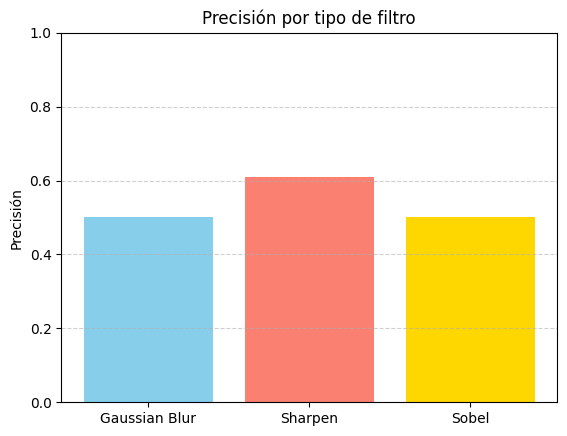

In [26]:
filtros = ['Gaussian Blur', 'Sharpen', 'Sobel']
precisiones = [acc_blur, acc_sharp, acc_sobel]

plt.bar(filtros, precisiones, color=['skyblue', 'salmon', 'gold'])
plt.title("Precisión por tipo de filtro")
plt.ylabel("Precisión")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Sharpening muestra una mejor evaluación

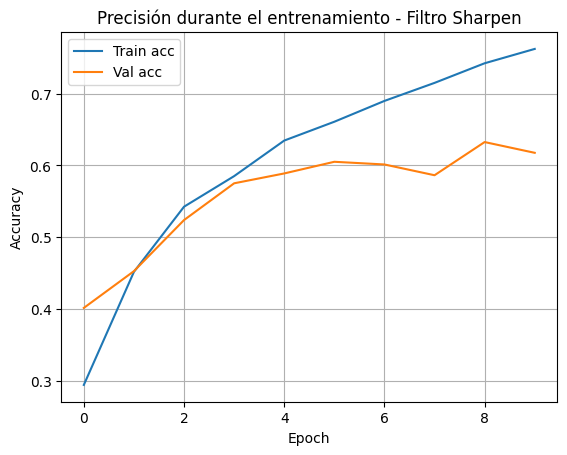

In [33]:
plt.plot(h_sharp.history['accuracy'], label='Train acc')
plt.plot(h_sharp.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión durante el entrenamiento - Filtro Sharpen')
plt.grid(True)
plt.show()

## Conclusión

Tras aplicar y comprarar los tres filtros (_GaussianBlur_, _Sobel_ y _Sharpen_), se observó que el filtro **Sharpen** otorgó una mayor precisión de clasificación sobre el mismo conjunto.